In [66]:
########################################
# IMPORTS
########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import joblib
import os

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [67]:
battery_data = pd.read_csv(r'/home/romulo/Documentos/PDC_codes/Battery_RUL.csv')

In [68]:
display(battery_data.iloc[577])

Cycle_Index                   599.000
Discharge Time (s)           1545.880
Decrement 3.6-3.4V (s)        463.125
Max. Voltage Dischar. (V)       3.910
Min. Voltage Charg. (V)         3.744
Time at 4.15V (s)            2807.250
Time constant current (s)    3752.000
Charging time (s)            8415.620
RUL                           514.000
Name: 577, dtype: float64

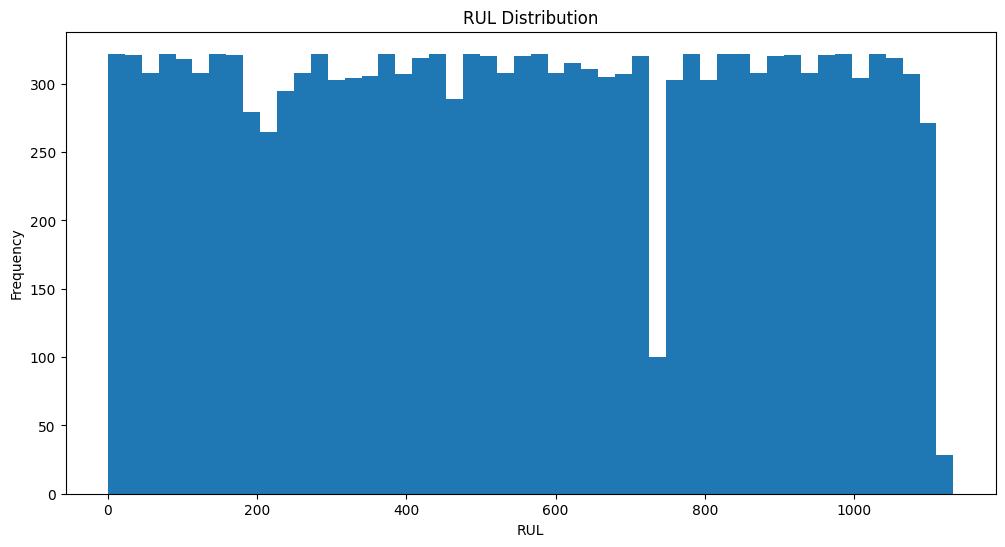


Basic Statistics of RUL:
count    15064.000000
mean       554.194172
std        322.434514
min          0.000000
25%        277.000000
50%        551.000000
75%        839.000000
max       1133.000000
Name: RUL, dtype: float64

Count of samples by RUL bins:
RUL_faixa
0-10         140
11-100      1259
101-500     5420
501-1000    6720
>1000       1511
Name: count, dtype: int64

Mean values of features by RUL bins:
           Discharge Time (s)  Decrement 3.6-3.4V (s)  \
RUL_faixa                                               
0-10               872.145286              218.319807   
11-100             939.101747              243.120661   
101-500           3043.328179             1193.247610   
501-1000          3853.463899             1002.798039   
>1000             9757.828776             2758.446782   

           Max. Voltage Dischar. (V)  Min. Voltage Charg. (V)  \
RUL_faixa                                                       
0-10                        3.769057                

In [69]:
# EXploratory Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. RUL Distribution
plt.figure(figsize=(12, 6))
plt.hist(battery_data['RUL'], bins=50)
plt.title('RUL Distribution')
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.show()

# 2. Basic Statistics
print("\nBasic Statistics of RUL:")
print(battery_data['RUL'].describe())

# 3. Count of samples by RUL bins
bins = [0, 10, 100, 500, 1000, float('inf')]
labels = ['0-10', '11-100', '101-500', '501-1000', '>1000']
battery_data['RUL_faixa'] = pd.cut(battery_data['RUL'], bins=bins, labels=labels)
print("\nCount of samples by RUL bins:")
print(battery_data['RUL_faixa'].value_counts().sort_index())

# 4. Analysis of features for different RULs
features = ['Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Max. Voltage Dischar. (V)', 
           'Min. Voltage Charg. (V)', 'Time at 4.15V (s)', 'Time constant current (s)', 
           'Charging time (s)']

# Mean values of features by RUL bins
print("\nMean values of features by RUL bins:")
print(battery_data.groupby('RUL_faixa')[features].mean())

# 5. Analysis of the last cycle (RUL = 0)
print("\nData of the last cycle (RUL = 0):")
print(battery_data[battery_data['RUL'] == 0][features])

# 6. Correlation between features and RUL
correlations = battery_data[features + ['RUL']].corr()['RUL'].sort_values()
print("\nCorrelation between features and RUL:")
print(correlations)

# Exploratory Data Analysis of Battery RUL Dataset

The analysis of the battery RUL dataset revealed important characteristics and challenges that explain the current performance of the predictive model. The dataset contains 15,064 records, with RUL values ranging from 0 to 1,133 cycles, showing an average of 554 cycles and a standard deviation of 322 cycles.

One of the most critical aspects identified is the significant imbalance in the data distribution. Most samples are concentrated in the RUL range between 501-1000 cycles (6,720 samples) and 101-500 cycles (5,420 samples). In contrast, there are only 140 samples for very low RULs (0-10 cycles) and 1,259 samples for RULs between 11-100 cycles. This imbalance explains partially why the model has difficulty making accurate predictions for batteries nearing the end of life.

The correlation analysis between features and RUL revealed that only two variables exhibit strong correlations: the maximum discharge voltage (positive correlation of 0.78) and the minimum charge voltage (negative correlation of -0.76). The other features show surprisingly low correlations, with values below 0.18, suggesting that many currently used variables may not be good predictors of RUL.

A particularly concerning issue identified in the data of end-of-life (RUL = 0) is that these records exhibit anomalous values in several features, with measurements orders of magnitude larger than the dataset average. For example, the discharge time shows values exceeding 670,000 seconds, while the average for other RUL ranges is typically below 10,000 seconds. These anomalies are likely measurement or recording errors and are significantly contributing to the high error in end-of-life predictions.

The analysis of the average values of features by RUL bin shows clear degradation trends, but also highlights the inconsistency of the data for low RULs. For example, the average discharge time drops from 9,757 seconds for new batteries (RUL > 1000) to just 872 seconds for batteries nearing the end of life (RUL 0-10), a reduction that appears to follow a logical pattern. However, other metrics show less consistent variations or even contradictory trends.

To improve the quality of predictions, especially for low RULs, several corrective measures will be necessary. First, it is essential to perform data cleaning to remove or correct the anomalies identified. Next, techniques for data balancing, such as SMOTE (Synthetic Minority Over-sampling Technique), can be applied to balance the representation of different RUL bins. Additionally, new derived features can be created to better capture the relationships between existing variables and the battery degradation process.


Finally, it is recommended to implement a stratified training strategy to ensure that all RUL bins are adequately represented during model training. These modifications should result in a more robust model capable of making more accurate predictions throughout the battery's entire life, especially in critical states near the end of life.




In [70]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def clean_dataset(df):
    print("Original dataset size:", len(df))
    
    # Calculate statistics to identify outliers
    stats = df.describe()
    
    # Define limits for each feature using the IQR method
    df_clean = df.copy()
    features = ['Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 
                'Time constant current (s)', 'Charging time (s)']
    
    for feature in features:
        Q1 = stats.loc['25%', feature]
        Q3 = stats.loc['75%', feature]
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Aplicar filtro
        df_clean = df_clean[
            (df_clean[feature] >= lower_bound) & 
            (df_clean[feature] <= upper_bound)
        ]
    
    print("Size after removing anomalies:", len(df_clean))
    return df_clean

def create_features(df):
    df_new = df.copy()
    
    # Features derivadas
    df_new['voltage_range'] = df_new['Max. Voltage Dischar. (V)'] - df_new['Min. Voltage Charg. (V)']
    df_new['charging_efficiency'] = df_new['Charging time (s)'] / df_new['Discharge Time (s)']
    df_new['voltage_decay_rate'] = df_new['Decrement 3.6-3.4V (s)'] / df_new['Discharge Time (s)']
    df_new['charging_speed'] = df_new['Time constant current (s)'] / df_new['Charging time (s)']
    
    # Remove derived features with infinite or NaN values
    df_new = df_new.replace([np.inf, -np.inf], np.nan)
    df_new = df_new.dropna()
    
    return df_new

def balance_by_stratified_sampling(df):
    # Create bins for RUL
    df['RUL_bin'] = pd.qcut(df['RUL'], q=10, labels=False)
    
    # Find the size of the smallest class
    min_size = df.groupby('RUL_bin').size().min()
    max_size = df.groupby('RUL_bin').size().max()
    print("Size of the smallest class:", min_size)
    print("Size of the largest class:", max_size)
    
    # Collect balanced samples
    balanced_samples = []
    for bin_label in df['RUL_bin'].unique():
        bin_data = df[df['RUL_bin'] == bin_label]
        balanced_samples.append(bin_data.sample(n=min_size, random_state=42))
    
    # Combine all samples
    df_balanced = pd.concat(balanced_samples)
    df_balanced = df_balanced.drop('RUL_bin', axis=1)
    
    print("\nSize of the dataset after balancing:", len(df_balanced))
    return df_balanced

def prepare_data(df):
    # Define features
    features = ['Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Max. Voltage Dischar. (V)',
                'Min. Voltage Charg. (V)', 'Time at 4.15V (s)', 'Time constant current (s)',
                'Charging time (s)', 'voltage_range', 'charging_efficiency', 
                'voltage_decay_rate', 'charging_speed']
    
    X = df[features].values
    y = df['RUL'].values
    
    # Normalization
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    
    return X_scaled, y_scaled, scaler_X, scaler_y

def process_dataset(df):
    print("Iniciando processamento do dataset...")
    
    # 1. Cleaning
    print("\nStep 1: Cleaning the data")
    df_clean = clean_dataset(df)
    
    # 2. Feature Engineering
    print("\nStep 2: Creating new features")
    df_featured = create_features(df_clean)
    print("New features created:", 
          [col for col in df_featured.columns if col not in df_clean.columns])
    
    # 3. Balancing
    print("\nStep 3: Balancing the dataset")
    df_balanced = balance_by_stratified_sampling(df_featured)
    
    # 4. Data preparation
    print("\nStep 4: Data preparation")
    X_scaled, y_scaled, scaler_X, scaler_y = prepare_data(df_balanced)
    
    # 5. Train/test split
    print("\nStep 5: Train/test split")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

battery_data = pd.read_csv('/home/romulo/Documentos/PDC_codes/Battery_RUL.csv')
X_train, X_test, y_train, y_test, scaler_X, scaler_y = process_dataset(battery_data)

# Check correlations
df_processed = create_features(clean_dataset(battery_data))
correlations = df_processed.corr()['RUL'].sort_values()
print("\nCorrelations with RUL (including new features):")
print(correlations)

np.save('X_train_processed.npy', X_train)
np.save('X_test_processed.npy', X_test)
np.save('y_train_processed.npy', y_train)
np.save('y_test_processed.npy', y_test)

Iniciando processamento do dataset...

Step 1: Cleaning the data
Original dataset size: 15064
Size after removing anomalies: 14615

Step 2: Creating new features
New features created: ['voltage_range', 'charging_efficiency', 'voltage_decay_rate', 'charging_speed']

Step 3: Balancing the dataset
Size of the smallest class: 1452
Size of the largest class: 1473

Size of the dataset after balancing: 14520

Step 4: Data preparation

Step 5: Train/test split
Original dataset size: 15064
Size after removing anomalies: 14615

Correlations with RUL (including new features):
Cycle_Index                 -0.999752
charging_efficiency         -0.886996
Min. Voltage Charg. (V)     -0.806098
voltage_decay_rate           0.756862
Charging time (s)            0.897690
voltage_range                0.908241
Max. Voltage Dischar. (V)    0.957817
Decrement 3.6-3.4V (s)       0.964596
charging_speed               0.973543
Time constant current (s)    0.982676
Time at 4.15V (s)            0.985559
Discharge 

Modelo corrigido 

In [71]:
df_processed.iloc[554]

Cycle_Index                   599.000000
Discharge Time (s)           1545.880000
Decrement 3.6-3.4V (s)        463.125000
Max. Voltage Dischar. (V)       3.910000
Min. Voltage Charg. (V)         3.744000
Time at 4.15V (s)            2807.250000
Time constant current (s)    3752.000000
Charging time (s)            8415.620000
RUL                           514.000000
voltage_range                   0.166000
charging_efficiency             5.443903
voltage_decay_rate              0.299587
charging_speed                  0.445838
Name: 577, dtype: float64

Iniciando processamento do dataset...

Etapa 1: Limpeza dos dados
Tamanho original do dataset: 15064
Tamanho após remoção de anomalias: 14615

Etapa 2: Criação de novas features
Novas features criadas: ['charging_efficiency', 'charging_speed', 'voltage_range', 'voltage_decay_rate']

Etapa 3: Balanceamento do dataset

Tamanho do dataset após balanceamento: 14520

Etapa 4: Preparação dos dados (escalonamento)

Etapa 5: Divisão treino/teste
Tamanho original do dataset: 15064
Tamanho após remoção de anomalias: 14615

Correlações com RUL (incluindo novas features):
Cycle_Index                 -0.999752
charging_efficiency         -0.886996
Min. Voltage Charg. (V)     -0.806098
voltage_decay_rate           0.756862
Charging time (s)            0.897690
voltage_range                0.908241
Max. Voltage Dischar. (V)    0.957817
Decrement 3.6-3.4V (s)       0.964596
charging_speed               0.973543
Time constant current (s)    0.982676
Time at 4.15V (s)            0.985559
Discharge Time 

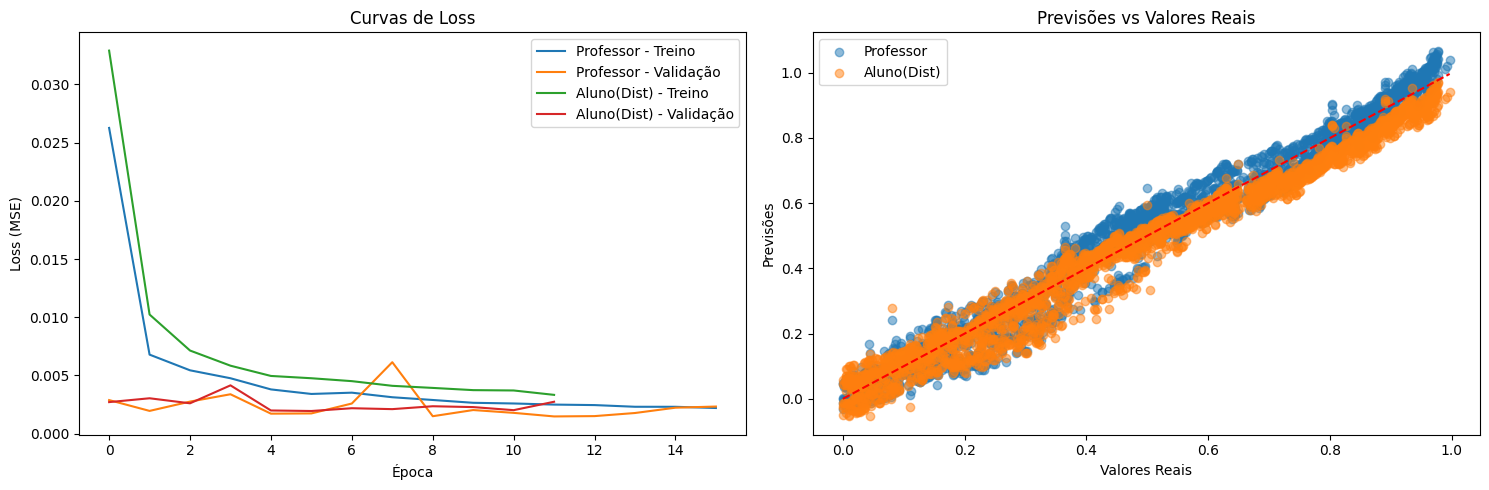


Tamanhos (na RAM, aproximado):
Teacher: 584.51 KB
Student(Dist): 52.80 KB
Razão de Compressão: 11.07x

Tamanhos (no disco, em .pth):
Teacher: 592.78 KB
Student(Dist): 57.51 KB

Tamanho do modelo Aluno Quantizado (no disco): 26.67 KB


In [73]:


########################################
# 1) PRE-PROCESSAMENTO
########################################

def clean_dataset(df):
    print("Tamanho original do dataset:", len(df))
    
    stats = df.describe()
    
    # Definir limites de IQR para algumas colunas
    features = [
        'Discharge Time (s)', 
        'Decrement 3.6-3.4V (s)', 
        'Time constant current (s)', 
        'Charging time (s)'
    ]
    
    df_clean = df.copy()
    for feature in features:
        Q1 = stats.loc['25%', feature]
        Q3 = stats.loc['75%', feature]
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_clean = df_clean[
            (df_clean[feature] >= lower_bound) &
            (df_clean[feature] <= upper_bound)
        ]
    
    print("Tamanho após remoção de anomalias:", len(df_clean))
    return df_clean

def create_features(df):
    df_new = df.copy()
    
    # Criando novas features
    df_new['voltage_range'] = df_new['Max. Voltage Dischar. (V)'] - df_new['Min. Voltage Charg. (V)']
    df_new['charging_efficiency'] = df_new['Charging time (s)'] / df_new['Discharge Time (s)']
    df_new['voltage_decay_rate'] = df_new['Decrement 3.6-3.4V (s)'] / df_new['Discharge Time (s)']
    df_new['charging_speed'] = df_new['Time constant current (s)'] / df_new['Charging time (s)']
    
    # Tratar infinito e NaN
    df_new = df_new.replace([np.inf, -np.inf], np.nan)
    df_new = df_new.dropna()
    
    return df_new

def balance_by_stratified_sampling(df):
    # Criar bins para RUL
    df = df.copy()
    df['RUL_bin'] = pd.qcut(df['RUL'], q=10, labels=False)
    
    # Encontrar o tamanho da menor classe
    min_size = df.groupby('RUL_bin').size().min()
    
    # Amostragem balanceada
    balanced_samples = []
    for bin_label in df['RUL_bin'].unique():
        bin_data = df[df['RUL_bin'] == bin_label]
        balanced_samples.append(bin_data.sample(n=min_size, random_state=42))
    
    df_balanced = pd.concat(balanced_samples).drop('RUL_bin', axis=1)
    df_balanced = df_balanced.sample(frac=1.0, random_state=42).reset_index(drop=True)
    
    print("\nTamanho do dataset após balanceamento:", len(df_balanced))
    return df_balanced

def prepare_data(df):
    # Definir quais colunas usar como features
    features = [
        'Discharge Time (s)', 
        'Decrement 3.6-3.4V (s)', 
        'Max. Voltage Dischar. (V)',
        'Min. Voltage Charg. (V)', 
        'Time at 4.15V (s)', 
        'Time constant current (s)',
        'Charging time (s)', 
        'voltage_range', 
        'charging_efficiency',
        'voltage_decay_rate', 
        'charging_speed'
    ]
    
    X = df[features].values
    y = df['RUL'].values
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    
    return X_scaled, y_scaled, scaler_X, scaler_y

def process_dataset(df):
    print("Iniciando processamento do dataset...")
    
    print("\nEtapa 1: Limpeza dos dados")
    df_clean = clean_dataset(df)
    
    print("\nEtapa 2: Criação de novas features")
    df_featured = create_features(df_clean)
    new_cols = set(df_featured.columns) - set(df_clean.columns)
    print("Novas features criadas:", list(new_cols))
    
    print("\nEtapa 3: Balanceamento do dataset")
    df_balanced = balance_by_stratified_sampling(df_featured)
    
    print("\nEtapa 4: Preparação dos dados (escalonamento)")
    X_scaled, y_scaled, scaler_X, scaler_y = prepare_data(df_balanced)
    
    print("\nEtapa 5: Divisão treino/teste")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

########################################
# 2) MODELOS (Teacher e Student)
########################################

class TeacherModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(TeacherModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, 
                            batch_first=True, bidirectional=True)
        self.batch_norm = nn.BatchNorm1d(hidden_size*2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(hidden_size*2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        # x: (batch_size, input_size)
        # LSTM espera (batch_size, seq_len, input_size). Vamos fingir seq_len=1
        x = x.unsqueeze(1)  # (batch_size, 1, input_size)
        
        lstm_out, _ = self.lstm(x)  # (batch_size, 1, 2*hidden_size)
        lstm_out = lstm_out[:, -1, :]  # (batch_size, 2*hidden_size)
        
        x = self.batch_norm(lstm_out)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

class StudentModel(nn.Module):
    def __init__(self, input_size, hidden_size=48):
        super(StudentModel, self).__init__()
        # Exemplo de "peso" que ajustaria cada feature antes de entrar no LSTM
        self.feature_weights = nn.Parameter(torch.ones(input_size))
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        # x: (batch_size, input_size)
        # Ajuste por feature_weights
        x = x * self.feature_weights  
        
        # LSTM espera (batch_size, seq_len, input_size)
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        
        # Pega a última saída do LSTM
        lstm_out = lstm_out[:, -1, :]
        
        x = self.batch_norm(lstm_out)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.output(x)
        return x

########################################
# 3) FUNÇÕES DE TREINO/EVAL
########################################

class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            if self.restore_best_weights:
                self.best_weights = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            if self.restore_best_weights:
                self.best_weights = model.state_dict()
            self.counter = 0
            
    def restore(self, model):
        if self.restore_best_weights and self.best_weights is not None:
            model.load_state_dict(self.best_weights)

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, target)
            total_loss += loss.item()
            predictions.extend(outputs.numpy().flatten())
            targets.extend(target.numpy().flatten())
    return total_loss / len(dataloader), predictions, targets

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs,
                scheduler=None, early_stopping=None, warmup_epochs=3):
    """
    Treinamento "padrão", usado aqui para o Professor.
    """
    train_losses = []
    val_losses = []
    initial_lr = optimizer.param_groups[0]['lr']
    
    for epoch in range(epochs):
        # Learning rate warmup
        if epoch < warmup_epochs:
            lr = initial_lr * (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss, _, _ = evaluate_model(model, val_loader, criterion)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if scheduler is not None and epoch >= warmup_epochs:
            scheduler.step(val_loss)
            
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | "
              f"LR={optimizer.param_groups[0]['lr']:.6f}")
        
        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping triggered!")
                early_stopping.restore(model)
                break
                
    return (train_losses, val_losses)

def train_student_with_distillation(student, teacher, train_loader, val_loader, 
                                    criterion, alpha, optimizer, epochs,
                                    scheduler=None, early_stopping=None, warmup_epochs=3):
    """
    Treinamento do Aluno com distilação do Professor:
    loss_final = alpha*MSE(Aluno, Rótulo) + (1-alpha)*MSE(Aluno, Professor)
    """
    train_losses = []
    val_losses = []
    initial_lr = optimizer.param_groups[0]['lr']

    teacher.eval()
    
    for epoch in range(epochs):
        # Learning rate warmup
        if epoch < warmup_epochs:
            lr = initial_lr * (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        student.train()
        train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            with torch.no_grad():
                teacher_pred = teacher(inputs)
            
            student_pred = student(inputs)
            
            loss_supervised = criterion(student_pred, targets)
            loss_distill = criterion(student_pred, teacher_pred)
            
            loss = alpha * loss_supervised + (1 - alpha) * loss_distill
            
            loss.backward()
            nn.utils.clip_grad_norm_(student.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss, _, _ = evaluate_model(student, val_loader, criterion)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if scheduler is not None and epoch >= warmup_epochs:
            scheduler.step(val_loss)
            
        print(f"[Distillation] Epoch {epoch+1}/{epochs} | "
              f"Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | "
              f"LR={optimizer.param_groups[0]['lr']:.6f}")
        
        if early_stopping is not None:
            early_stopping(val_loss, student)
            if early_stopping.early_stop:
                print("Early stopping triggered!")
                early_stopping.restore(student)
                break
                
    return (train_losses, val_losses)

########################################
# 4) CARREGAR, PROCESSAR E TREINAR
########################################

# Exemplo de leitura de dados (ajuste o caminho conforme necessário)
battery_data = pd.read_csv('/home/romulo/Documentos/PDC_codes/Battery_RUL.csv')

# Processar dataset
X_train, X_test, y_train, y_test, scaler_X, scaler_y = process_dataset(battery_data)

# Salvar scalers
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

# (Opcional) Ver correlações
df_tmp = create_features(clean_dataset(battery_data))
correlations = df_tmp.corr()['RUL'].sort_values()
print("\nCorrelações com RUL (incluindo novas features):")
print(correlations)

# Salvar dados processados em npy
np.save('X_train_processed.npy', X_train)
np.save('X_test_processed.npy', X_test)
np.save('y_train_processed.npy', y_train)
np.save('y_test_processed.npy', y_test)

########################################
# Preparar DataLoaders
########################################

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

########################################
# 4.1) Treinar Professor
########################################

input_size = X_train.shape[1]
criterion = nn.MSELoss()

teacher = TeacherModel(input_size)
teacher_optimizer = optim.Adam(teacher.parameters(), lr=0.0005)
teacher_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    teacher_optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)
early_stopping_teacher = EarlyStopping(patience=7, restore_best_weights=True)

print("\nTreinando modelo Professor...\n")
teacher_losses = train_model(
    model=teacher,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=teacher_optimizer,
    epochs=50,
    scheduler=teacher_scheduler,
    early_stopping=early_stopping_teacher,
    warmup_epochs=3
)

########################################
# 4.2) Treinar Aluno com Distilação
########################################

student = StudentModel(input_size)
student_optimizer = optim.Adam(student.parameters(), lr=0.0005)
student_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    student_optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)
early_stopping_student = EarlyStopping(patience=7, restore_best_weights=True)

alpha = 0.7  # Peso da loss supervisionada vs. distilada

print(f"\nTreinando modelo Aluno com distilação (alpha={alpha})...\n")
student_losses = train_student_with_distillation(
    student=student,
    teacher=teacher,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    alpha=alpha,
    optimizer=student_optimizer,
    epochs=50,
    scheduler=student_scheduler,
    early_stopping=early_stopping_student,
    warmup_epochs=3
)

########################################
# 5) AVALIAÇÃO E PLOTS
########################################

print("\nAvaliando modelos...")
teacher_loss, teacher_pred, teacher_true = evaluate_model(teacher, test_loader, criterion)
student_loss, student_pred, student_true = evaluate_model(student, test_loader, criterion)

print(f"Loss final do Professor: {teacher_loss:.4f}")
print(f"Loss final do Aluno (Distilado): {student_loss:.4f}")

plt.figure(figsize=(15, 5))

# (5.1) Curvas de Loss
plt.subplot(1, 2, 1)
plt.plot(teacher_losses[0], label='Professor - Treino')
plt.plot(teacher_losses[1], label='Professor - Validação')
plt.plot(student_losses[0], label='Aluno(Dist) - Treino')
plt.plot(student_losses[1], label='Aluno(Dist) - Validação')
plt.title('Curvas de Loss')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.legend()

# (5.2) Predições vs. Valores Reais
plt.subplot(1, 2, 2)
plt.scatter(teacher_true, teacher_pred, alpha=0.5, label='Professor')
plt.scatter(student_true, student_pred, alpha=0.5, label='Aluno(Dist)')
min_val = min(teacher_true + student_true)
max_val = max(teacher_true + student_true)
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('Previsões vs Valores Reais')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.legend()

plt.tight_layout()
plt.show()

########################################
# 6) COMPARAÇÃO DE TAMANHO E QUANTIZAÇÃO
########################################

def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_kb = (param_size + buffer_size) / 1024
    return size_kb

def get_model_disk_size(model, path="temp.pth"):
    torch.save(model.state_dict(), path)
    size_kb = os.path.getsize(path) / 1024
    os.remove(path)
    return size_kb

teacher_size = get_model_size(teacher)
student_size = get_model_size(student)
print("\nTamanhos (na RAM, aproximado):")
print(f"Teacher: {teacher_size:.2f} KB")
print(f"Student(Dist): {student_size:.2f} KB")
print(f"Razão de Compressão: {teacher_size / student_size:.2f}x")

teacher_disk = get_model_disk_size(teacher, "teacher_temp.pth")
student_disk = get_model_disk_size(student, "student_temp.pth")
print("\nTamanhos (no disco, em .pth):")
print(f"Teacher: {teacher_disk:.2f} KB")
print(f"Student(Dist): {student_disk:.2f} KB")

# Exemplo simples de quantização pós-treinamento (atenção: LSTM quantizado tem suporte limitado)
def quantize_student_model(student_model, data_loader):
    """
    Exemplo de quantização estática pós-treinamento.
    Em LSTMs, normalmente não funciona bem sem modificações adicionais.
    Mas segue um exemplo simples de quantizar as camadas lineares.
    """
    # Copia do modelo
    model_to_quant = StudentModel(input_size)
    model_to_quant.load_state_dict(student_model.state_dict())
    model_to_quant.eval()

    # Definir configuração de quantização (APENAS para camadas lineares)
    model_to_quant.qconfig = torch.quantization.default_qconfig
    
    # Prepara (inplace=False retorna outro modelo)
    model_prepared = torch.quantization.prepare(model_to_quant, inplace=False)
    
    # Loop de calibração
    with torch.no_grad():
        for inputs, _ in data_loader:
            model_prepared(inputs)
    
    # Converte para modelo quantizado
    model_quantized = torch.quantization.convert(model_prepared, inplace=False)
    
    return model_quantized

student_quantized = quantize_student_model(student, train_loader)
torch.save(student_quantized.state_dict(), "student_quantized.pth")

quant_disk_size = get_model_disk_size(student_quantized, "quantized_temp.pth")
print(f"\nTamanho do modelo Aluno Quantizado (no disco): {quant_disk_size:.2f} KB")


In [74]:
def process_new_data_for_inference(df_new, scaler_X):
    """
    Aplica o mesmo pipeline de limpeza e feature engineering,
    mas NÃO faz balanceamento e NÃO refaz fit do scaler.
    
    Returns: X_infer (scaled numpy array)
    """
    # 1) (Optional-Not recommended in production) Outlier cleaning
  
    # df_clean = clean_dataset(df_new)
    
    # 2) Feature engineering
    df_featured = create_features(df_new)
    # df_featured = create_features(df_clean)
    
    # 3) Build feature array
    features = [
        'Discharge Time (s)', 
        'Decrement 3.6-3.4V (s)', 
        'Max. Voltage Dischar. (V)',
        'Min. Voltage Charg. (V)', 
        'Time at 4.15V (s)', 
        'Time constant current (s)',
        'Charging time (s)', 
        'voltage_range', 
        'charging_efficiency', 
        'voltage_decay_rate', 
        'charging_speed'
    ]
    X_new = df_featured[features].values
    
    # 4) Scale (using transform, NOT fit_transform)
    X_infer = scaler_X.transform(X_new)
    
    return X_infer, df_featured  # df_featured



In [75]:
def predict_rul_in_pipeline(df_novo):
    """
    Full inference pipeline for new data 'df_novo'
    (without resampling, but with the same transformations).
    Returns RUL predictions and the resulting DataFrame.
    """
    # 1) Load scalers and model
    scaler_X = joblib.load("scaler_X.pkl")
    scaler_y = joblib.load("scaler_y.pkl")
    
    # 2) Load and initialize the model
    input_size = 11  # must be the same as training
    model = StudentModel(input_size=input_size)
    state_dict = torch.load("/home/romulo/Documentos/PDC_codes/student_model.pth")
    model.load_state_dict(state_dict)
    model.eval()
    
    # 3) Apply preprocessing pipeline (without balancing)
    X_infer, df_feat = process_new_data_for_inference(df_novo, scaler_X)
    
    # 4) Convert X_infer to tensor
    X_tensor = torch.FloatTensor(X_infer)
    
    # 5) Make prediction
    with torch.no_grad():
        pred_scaled = model(X_tensor)
    
    # 6) Descale RUL
    pred_np = pred_scaled.numpy().reshape(-1, 1)
    rul_pred = scaler_y.inverse_transform(pred_np).ravel()
    rul_pred = np.clip(rul_pred, a_min=0, a_max=None)
    
    # 7) Add prediction column to DataFrame
    df_feat["RUL_pred"] = rul_pred
    
    return rul_pred, df_feat


if __name__ == "__main__":
    # (must contain at least: Discharge Time (s), Decrement 3.6-3.4V (s), etc.)
#     df_novo = pd.DataFrame({
#     "Cycle_Index": [362, 610],
#     "Discharge Time (s)": [5500, 5800],
#     "Decrement 3.6-3.4V (s)": [950, 1000],
#     "Max. Voltage Dischar. (V)": [4.07, 4.05],
#     "Min. Voltage Charg. (V)": [3.35, 3.33],
#     "Time at 4.15V (s)": [2300, 2100],
#     "Time constant current (s)": [3600, 3700],
#     "Charging time (s)": [6000, 6150],
#     # RUL apenas para referência 
#     "RUL": [750, 700]
# })

#     df_novo = pd.DataFrame({
#     "Cycle_Index": [28.000000],
#     "Discharge Time (s)": [2234.380000],
#     "Decrement 3.6-3.4V (s)": [852.000000],
#     "Max. Voltage Dischar. (V)": [4.045000],
#     "Min. Voltage Charg. (V)": [3.378000],
#     "Time at 4.15V (s)": [5118.368000],
#     "Time constant current (s)": [6091.360000],
#     "Charging time (s)": [9176.380000],
#     "RUL": [1085.000000]
# })
    
    df_novo = pd.DataFrame({
    "Cycle_Index": [599.000000],
    "Discharge Time (s)": [1545.880000],
    "Decrement 3.6-3.4V (s)": [463.125000],
    "Max. Voltage Dischar. (V)": [3.910000],
    "Min. Voltage Charg. (V)": [3.744000],
    "Time at 4.15V (s)": [2807.250000],
    "Time constant current (s)": [3752.000000],
    "Charging time (s)": [8415.620000],
    "RUL": [514.000000]
})


    # Predict
    rul_pred, df_pred = predict_rul_in_pipeline(df_novo)
    # rul_pred_clamped = np.clip(rul_pred, 0, 1112)  # Fake data not representative of training data


    print("Predições de RUL:", rul_pred)
    print(df_pred)


Predições de RUL: [538.9088]
   Cycle_Index  Discharge Time (s)  Decrement 3.6-3.4V (s)  \
0        599.0             1545.88                 463.125   

   Max. Voltage Dischar. (V)  Min. Voltage Charg. (V)  Time at 4.15V (s)  \
0                       3.91                    3.744            2807.25   

   Time constant current (s)  Charging time (s)    RUL  voltage_range  \
0                     3752.0            8415.62  514.0          0.166   

   charging_efficiency  voltage_decay_rate  charging_speed    RUL_pred  
0             5.443903            0.299587        0.445838  538.908813  


/tmp/ipykernel_11014/3845991306.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/home/romulo/Documentos/PDC_codes/student_model.pth")


In [76]:
from evaluation import evaluate_model

# Avaliar modelo Professor
teacher_metrics = evaluate_model(teacher, test_loader, criterion)

# Avaliar modelo Aluno
student_metrics = evaluate_model(student, test_loader, criterion)

# Comparar resultados
print("\nModel Comparison:")
print("Teacher vs Student Performance:")
print(f"Teacher Overall MSE: {teacher_metrics['overall']['mse']:.4f}")
print(f"Student Overall MSE: {student_metrics['overall']['mse']:.4f}")
print(f"Size Reduction: {100*(1 - student_size/teacher_size):.1f}%")


Overall Metrics:
MSE: 0.0023
MAE: 0.0384
R²: 0.9713

Performance by RUL Range:

RUL Range 0-100:
MSE: 0.0023
MAE: 0.0384
R²: 0.9713

Overall Metrics:
MSE: 0.0027
MAE: 0.0427
R²: 0.9662

Performance by RUL Range:

RUL Range 0-100:
MSE: 0.0027
MAE: 0.0427
R²: 0.9662

Model Comparison:
Teacher vs Student Performance:
Teacher Overall MSE: 0.0023
Student Overall MSE: 0.0027
Size Reduction: 91.0%
